In [53]:
!pip install tensorflow_addons

ERROR: Could not find a version that satisfies the requirement tensorflow_addons (from versions: none)

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow_addons


In [54]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import json
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications, optimizers, callbacks, mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [55]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [56]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [57]:
class Config:
    # Paths
    DATA_PATH = "../data/Augmented_images"  
    MODEL_SAVE_PATH = "../models" 
    LOGS_PATH = "/logs"
    
    # Image parameters
    IMG_SIZE = (224, 224)  # Standard for EfficientNet/ViT
    CHANNELS = 3
    BATCH_SIZE = 32  # Reduced for ViT memory constraints
    NUM_CLASSES = 10
    
    # Training parameters
    EPOCHS = 50
    PATIENCE = 15
    INITIAL_LR = 1e-4  # Lower learning rate for medical images
    MIN_LR = 1e-7
    
    # Model parameters
    DROPOUT_RATE = 0.5
    HIDDEN_UNITS = 256
    
    # K-Fold Cross Validation
    N_SPLITS = 5
    
    # Grad-CAM
    GRAD_CAM_LAYER = 'top_conv'  # Layer for Grad-CAM visualization
    
    # Medical-specific parameters
    FOCAL_LOSS_ALPHA = 0.25
    FOCAL_LOSS_GAMMA = 2.0
    CLASS_WEIGHTS = {}  # Will be computed based on distribution

In [58]:
CLASS_NAMES = [
    'Central_Serous_Chorioretinopathy',
    'Diabetic_Retinopathy',
    'Disc_Edema',
    'Glaucoma',
    'Healthy',
    'Macular_Scar',
    'Myopia',
    'Pterygium',
    'Retinal_Detachment',
    'Retinitis_Pigmentosa'
]

In [59]:
CLASS_NAMES_SHORT = [name.split()[0] for name in CLASS_NAMES]

In [60]:
def explore_dataset(data_path, class_names):
    """Comprehensive dataset exploration"""
    
    print("🔍 Exploring Dataset...")
    print("=" * 50)
    
    class_counts = {}
    image_info = []
    
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        if not os.path.exists(class_path):
            print(f"⚠️ Warning: Path {class_path} does not exist!")
            continue
            
        images = os.listdir(class_path)
        class_counts[class_name] = len(images)
        
        # Check sample images
        if images:
            sample_img = os.path.join(class_path, images[0])
            try:
                img = Image.open(sample_img)
                width, height = img.size
                mode = img.mode
                image_info.append({
                    'class': class_name,
                    'count': len(images),
                    'width': width,
                    'height': height,
                    'mode': mode
                })
            except Exception as e:
                print(f"Error reading {sample_img}: {e}")
    
    # Display statistics
    df_stats = pd.DataFrame(image_info)
    print("\n📊 Dataset Statistics:")
    print(df_stats.describe())
    
    print("\n📈 Class Distribution:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} images")
    
    return class_counts, df_stats

In [61]:
def visualize_dataset(class_counts, data_path, class_names):
    """Enhanced visualization of dataset"""
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Dataset Analysis and Visualization', fontsize=16, fontweight='bold')
    
    # 1. Class Distribution Bar Plot
    axes[0, 0].barh(list(class_counts.keys()), list(class_counts.values()))
    axes[0, 0].set_title('Class Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Number of Images')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Pie Chart
    axes[0, 1].pie(class_counts.values(), labels=class_counts.keys(), 
                   autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Class Proportion', fontsize=12, fontweight='bold')
    
    # 3. Sample Images Grid (3x3)
    sample_images = []
    for class_name in class_names[:3]:  # Show first 3 classes
        class_path = os.path.join(data_path, class_name)
        if os.path.exists(class_path):
            images = os.listdir(class_path)
            if images:
                img_path = os.path.join(class_path, random.choice(images))
                sample_images.append((class_name, img_path))
    
    for idx, (class_name, img_path) in enumerate(sample_images):
        row = idx // 3
        col = idx % 3
        try:
            img = Image.open(img_path)
            axes[1, col].imshow(img)
            axes[1, col].set_title(f'{class_name}', fontsize=10)
            axes[1, col].axis('off')
        except:
            axes[1, col].text(0.5, 0.5, 'Image\nNot Found', 
                             ha='center', va='center')
            axes[1, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 4. Image Statistics
    fig2, axes2 = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram of image counts
    axes2[0].hist(list(class_counts.values()), bins=20, edgecolor='black', alpha=0.7)
    axes2[0].set_title('Distribution of Images per Class', fontsize=12, fontweight='bold')
    axes2[0].set_xlabel('Number of Images')
    axes2[0].set_ylabel('Frequency')
    axes2[0].grid(True, alpha=0.3)
    
    # Box plot
    axes2[1].boxplot(list(class_counts.values()))
    axes2[1].set_title('Box Plot of Class Distribution', fontsize=12, fontweight='bold')
    axes2[1].set_ylabel('Number of Images')
    axes2[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [62]:
class MedicalAugmentation:
    """Medical image specific augmentation techniques"""
    
    @staticmethod
    def get_train_augmentations():
        """Augmentations suitable for retinal images"""
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,  # Limited rotation for medical images
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,  # Added for retinal symmetry
            brightness_range=[0.8, 1.2],  # Adjust brightness
            fill_mode='reflect',
            validation_split=0.2
        )
    
    @staticmethod
    def get_val_test_augmentations():
        """Only rescaling for validation/test"""
        return ImageDataGenerator(rescale=1./255)
    
    @staticmethod
    def add_special_augmentations(image):
        """Apply medical-specific augmentations"""
        # Add Gaussian noise (mimics image noise)
        if random.random() > 0.5:
            noise = np.random.normal(0, 0.01, image.shape)
            image = np.clip(image + noise, 0, 1)
        
        # Adjust contrast
        if random.random() > 0.5:
            mean = np.mean(image)
            image = np.clip((image - mean) * random.uniform(0.9, 1.1) + mean, 0, 1)
        
        return image

In [63]:
def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss for handling class imbalance"""
    def focal_loss_fixed(y_true, y_pred):
        epsilon = keras.backend.epsilon()
        y_pred = keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        
        # Calculate cross entropy
        cross_entropy = -y_true * keras.backend.log(y_pred)
        
        # Calculate weight
        weight = alpha * y_true * keras.backend.pow((1 - y_pred), gamma)
        
        # Focal loss
        loss = weight * cross_entropy
        
        # Sum over classes
        loss = keras.backend.sum(loss, axis=1)
        return loss
    return focal_loss_fixed


In [64]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice coefficient for segmentation-like tasks"""
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + smooth)


In [65]:
def dice_loss(y_true, y_pred):
    """Dice loss"""
    return 1 - dice_coefficient(y_true, y_pred)

In [66]:
def combined_loss(alpha=0.5, beta=0.5):
    """Combine focal loss and dice loss"""
    def combined_loss_fixed(y_true, y_pred):
        fl = focal_loss()(y_true, y_pred)
        dl = dice_loss(y_true, y_pred)
        return alpha * fl + beta * dl
    return combined_loss_fixed

In [67]:
def create_efficientnet_model(input_shape=(224, 224, 3), num_classes=10):
    """Create EfficientNetB3 model with medical adaptations"""
    
    # Base model
    base_model = applications.EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling=None
    )
    
    # Freeze initial layers
    base_model.trainable = False
    
    inputs = keras.Input(shape=input_shape)
    
    # Preprocess for EfficientNet
    x = applications.efficientnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    
    # Add attention mechanism
    x = layers.Conv2D(256, 1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Squeeze and Excitation Block
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(256 // 16, activation='relu')(se)
    se = layers.Dense(256, activation='sigmoid')(se)
    x = layers.multiply([x, se])
    
    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense layers with regularization
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    model = keras.Model(inputs, outputs, name='EfficientNet_Medical')
    
    return model, base_model

In [68]:
def create_vit_model(input_shape=(224, 224, 3), num_classes=10):
    """Create Vision Transformer model"""
    
    # Parameters
    patch_size = 16  # 16x16 patches
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    projection_dim = 128
    num_heads = 8
    transformer_layers = 6
    mlp_head_units = [512, 256]
    
    def mlp(x, hidden_units, dropout_rate):
        for units in hidden_units:
            x = layers.Dense(units, activation=tf.nn.gelu)(x)
            x = layers.Dropout(dropout_rate)(x)
        return x
    
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Create patches
    x = layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="VALID",
        name='patch_conv'
    )(inputs)
    
    patches = layers.Reshape((num_patches, projection_dim))(x)
    
    # Position embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )(positions)
    
    # Add position embedding to patches
    encoded_patches = layers.Add()([patches, position_embedding])
    
    # Transformer blocks
    for _ in range(transformer_layers):
        # Layer normalization
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        
        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=[projection_dim * 2, projection_dim], dropout_rate=0.1)
        
        encoded_patches = layers.Add()([x3, x2])
    
    # Classification head
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    # MLP head
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    
    # Output layer
    logits = layers.Dense(num_classes, activation='softmax', dtype='float32')(features)
    
    model = keras.Model(inputs=inputs, outputs=logits, name='VisionTransformer')
    
    return model

In [69]:
def create_ensemble_model(cnn_model, vit_model, num_classes=10):
    """Create ensemble of CNN and ViT models"""
    
    # Input
    inputs = keras.Input(shape=(224, 224, 3))
    
    # Get predictions from both models
    cnn_features = cnn_model(inputs)
    vit_features = vit_model(inputs)
    
    # Weighted average ensemble
    alpha = 0.6  # Weight for CNN
    beta = 0.4   # Weight for ViT
    
    # Combine predictions
    combined = layers.average([cnn_features * alpha, vit_features * beta])
    
    # Final output
    outputs = layers.Activation('softmax', dtype='float32')(combined)
    
    ensemble_model = keras.Model(
        inputs=inputs, 
        outputs=outputs, 
        name='CNN_ViT_Ensemble'
    )
    
    return ensemble_model

In [70]:
class MedicalMetrics:
    """Custom metrics for medical image classification"""
    
    @staticmethod
    def specificity(y_true, y_pred):
        """Calculate specificity (True Negative Rate)"""
        true_negatives = keras.backend.sum(
            keras.backend.round(keras.backend.clip((1 - y_true) * (1 - y_pred), 0, 1))
        )
        possible_negatives = keras.backend.sum(
            keras.backend.round(keras.backend.clip(1 - y_true, 0, 1))
        )
        return true_negatives / (possible_negatives + keras.backend.epsilon())
    
    @staticmethod
    def sensitivity(y_true, y_pred):
        """Calculate sensitivity (Recall)"""
        true_positives = keras.backend.sum(
            keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1))
        )
        possible_positives = keras.backend.sum(
            keras.backend.round(keras.backend.clip(y_true, 0, 1))
        )
        return true_positives / (possible_positives + keras.backend.epsilon())
    
    @staticmethod
    def f1_score(y_true, y_pred):
        """Calculate F1-Score"""
        precision = keras.metrics.Precision()
        recall = keras.metrics.Recall()
        
        precision.update_state(y_true, y_pred)
        recall.update_state(y_true, y_pred)
        
        p = precision.result()
        r = recall.result()
        
        return 2 * ((p * r) / (p + r + keras.backend.epsilon()))

In [71]:
class GradCAM:
    """Grad-CAM visualization for model interpretability"""
    
    @staticmethod
    def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        """Generate Grad-CAM heatmap"""
        
        # Create model that maps input image to activations of last conv layer
        grad_model = keras.models.Model(
            [model.inputs], 
            [model.get_layer(last_conv_layer_name).output, model.output]
        )
        
        # Compute gradient of top predicted class for input image
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]
        
        # Gradient of output neuron with respect to output feature map
        grads = tape.gradient(class_channel, last_conv_layer_output)
        
        # Pool gradients over spatial dimensions
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Weight feature maps by gradient importance
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        
        # Normalize heatmap
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        
        return heatmap.numpy()
    
    @staticmethod
    def display_gradcam(img_path, heatmap, alpha=0.4):
        """Display original image with Grad-CAM overlay"""
        
        # Load original image
        img = keras.preprocessing.image.load_img(img_path)
        img = keras.preprocessing.image.img_to_array(img)
        
        # Resize heatmap to match image size
        heatmap = np.uint8(255 * heatmap)
        
        # Use jet colormap
        jet = plt.cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        
        # Create overlay
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
        
        # Superimpose
        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
        
        return superimposed_img

In [72]:
class AttentionVisualizer:
    """Visualize attention maps from Vision Transformer"""
    
    @staticmethod
    def get_attention_map(model, img_array, layer_index=-1):
        """Extract attention maps from ViT"""
        
        # Create model that returns attention weights
        attention_layer = model.layers[layer_index]
        attention_model = keras.models.Model(
            inputs=model.input,
            outputs=attention_layer.output
        )
        
        # Get attention weights
        attention_output = attention_model.predict(img_array)
        
        # Average attention weights across heads
        attention_map = np.mean(attention_output, axis=1)
        
        return attention_map
    
    @staticmethod
    def visualize_attention_map(img_path, attention_map):
        """Visualize attention map overlaid on image"""
        
        # Load image
        img = Image.open(img_path)
        img = img.resize((224, 224))
        
        # Reshape attention map
        patch_size = 16
        num_patches = (224 // patch_size) ** 2
        attention_map = attention_map[0, :num_patches, :num_patches]
        
        # Resize attention map to image size
        attention_map_resized = cv2.resize(
            attention_map, (224, 224), interpolation=cv2.INTER_LINEAR
        )
        
        # Normalize
        attention_map_resized = (attention_map_resized - attention_map_resized.min()) / \
                               (attention_map_resized.max() - attention_map_resized.min())
        
        # Create heatmap
        heatmap = cv2.applyColorMap(
            np.uint8(255 * attention_map_resized), 
            cv2.COLORMAP_JET
        )
        heatmap = np.float32(heatmap) / 255
        
        # Convert image to float
        img_array = np.array(img) / 255.0
        
        # Superimpose
        superimposed = heatmap + img_array
        superimposed = superimposed / np.max(superimposed)
        
        return superimposed

In [73]:
class KFoldCrossValidator:
    """Perform K-Fold Cross Validation"""
    
    def __init__(self, n_splits=5):
        self.n_splits = n_splits
        self.skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
        self.results = []
    
    def prepare_folds(self, image_paths, labels):
        """Prepare folds from dataset"""
        
        # Get all image paths and labels
        all_paths = []
        all_labels = []
        
        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_path = os.path.join(Config.DATA_PATH, class_name)
            if os.path.exists(class_path):
                images = os.listdir(class_path)
                for img_name in images:
                    img_path = os.path.join(class_path, img_name)
                    if os.path.exists(img_path):
                        all_paths.append(img_path)
                        all_labels.append(class_idx)
        
        return all_paths, all_labels
    
    def create_data_generators(self, train_idx, val_idx, all_paths, all_labels):
        """Create train and validation generators for a fold"""
        
        # Split paths and labels
        train_paths = [all_paths[i] for i in train_idx]
        train_labels = [all_labels[i] for i in train_idx]
        val_paths = [all_paths[i] for i in val_idx]
        val_labels = [all_labels[i] for i in val_idx]
        
        # Create dataframes
        train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
        val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})
        
        # Create custom generator
        train_datagen = MedicalAugmentation.get_train_augmentations()
        val_datagen = MedicalAugmentation.get_val_test_augmentations()
        
        def custom_generator(df, datagen, is_training=True):
            while True:
                for i in range(0, len(df), Config.BATCH_SIZE):
                    batch_df = df.iloc[i:i+Config.BATCH_SIZE]
                    images = []
                    labels = []
                    
                    for _, row in batch_df.iterrows():
                        try:
                            img = Image.open(row['filename']).resize(Config.IMG_SIZE)
                            img_array = np.array(img) / 255.0
                            
                            if is_training and random.random() > 0.5:
                                img_array = MedicalAugmentation.add_special_augmentations(img_array)
                            
                            images.append(img_array)
                            
                            # One-hot encode labels
                            label = tf.keras.utils.to_categorical(
                                row['class'], 
                                Config.NUM_CLASSES
                            )
                            labels.append(label)
                        except Exception as e:
                            continue
                    
                    if images:
                        yield np.array(images), np.array(labels)
        
        train_gen = custom_generator(train_df, train_datagen, is_training=True)
        val_gen = custom_generator(val_df, val_datagen, is_training=False)
        
        steps_per_epoch = len(train_df) // Config.BATCH_SIZE
        validation_steps = len(val_df) // Config.BATCH_SIZE
        
        return train_gen, val_gen, steps_per_epoch, validation_steps
    
    def run_cross_validation(self, create_model_fn):
        """Run K-Fold Cross Validation"""
        
        print(f"\n🔬 Starting {self.n_splits}-Fold Cross Validation")
        print("=" * 50)
        
        # Prepare data
        all_paths, all_labels = self.prepare_folds([], [])
        
        fold_no = 1
        all_history = []
        
        for train_idx, val_idx in self.skf.split(all_paths, all_labels):
            print(f"\n📁 Fold {fold_no}/{self.n_splits}")
            print("-" * 30)
            
            # Create data generators
            train_gen, val_gen, steps, val_steps = self.create_data_generators(
                train_idx, val_idx, all_paths, all_labels
            )
            
            # Create and train model
            model = create_model_fn()
            
            # Callbacks for this fold
            fold_callbacks = [
                callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=10,
                    restore_best_weights=True,
                    verbose=1
                ),
                callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=5,
                    min_lr=Config.MIN_LR,
                    verbose=1
                )
            ]
            
            # Train model
            history = model.fit(
                train_gen,
                steps_per_epoch=steps,
                validation_data=val_gen,
                validation_steps=val_steps,
                epochs=Config.EPOCHS,
                callbacks=fold_callbacks,
                verbose=1
            )
            
            # Evaluate
            val_loss, val_accuracy = model.evaluate(val_gen, steps=val_steps)
            print(f"Fold {fold_no} - Validation Accuracy: {val_accuracy:.4f}")
            
            # Store results
            self.results.append({
                'fold': fold_no,
                'accuracy': val_accuracy,
                'loss': val_loss,
                'history': history.history,
                'model': model
            })
            
            fold_no += 1
        
        # Print cross-validation results
        self.print_cv_results()
        
        return self.results
    
    def print_cv_results(self):
        """Print cross-validation results"""
        
        print("\n" + "=" * 50)
        print("📊 CROSS-VALIDATION RESULTS")
        print("=" * 50)
        
        accuracies = [result['accuracy'] for result in self.results]
        losses = [result['loss'] for result in self.results]
        
        print(f"\nFold Accuracies: {accuracies}")
        print(f"Fold Losses: {losses}")
        print(f"\nMean Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")
        print(f"Mean Loss: {np.mean(losses):.4f}")
        
        # Plot CV results
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Accuracy plot
        axes[0].plot(range(1, len(accuracies) + 1), accuracies, 'bo-')
        axes[0].axhline(y=np.mean(accuracies), color='r', linestyle='--', 
                       label=f'Mean: {np.mean(accuracies):.3f}')
        axes[0].set_xlabel('Fold')
        axes[0].set_ylabel('Accuracy')
        axes[0].set_title('Cross-Validation Accuracy per Fold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Loss plot
        axes[1].plot(range(1, len(losses) + 1), losses, 'ro-')
        axes[1].axhline(y=np.mean(losses), color='b', linestyle='--',
                       label=f'Mean: {np.mean(losses):.3f}')
        axes[1].set_xlabel('Fold')
        axes[1].set_ylabel('Loss')
        axes[1].set_title('Cross-Validation Loss per Fold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

In [74]:
def plot_roc_curves(y_true, y_pred_probs, class_names):
    """Plot ROC curves for each class"""
    
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred_probs[:, i])
    
    # Compute micro-average ROC curve and area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
    roc_auc["micro"] = roc_auc_score(y_true_bin, y_pred_probs, average="micro")
    
    # Plot ROC curves
    plt.figure(figsize=(12, 10))
    
    # Plot each class
    colors = plt.cm.Set1(np.linspace(0, 1, len(class_names)))
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    # Plot micro-average
    plt.plot(fpr["micro"], tpr["micro"],
            label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
            color='deeppink', linestyle=':', linewidth=4)
    
    # Plot diagonal
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves for Each Class', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add inset for average AUC
    ax_inset = plt.axes([0.6, 0.3, 0.3, 0.3])
    ax_inset.bar(range(len(class_names)), [roc_auc[i] for i in range(len(class_names))])
    ax_inset.set_xticks(range(len(class_names)))
    ax_inset.set_xticklabels([name[:3] for name in class_names], rotation=45)
    ax_inset.set_title('AUC per Class')
    ax_inset.set_ylim([0.5, 1.0])
    ax_inset.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print AUC scores
    print("\n📈 AUC Scores per Class:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {roc_auc[i]:.4f}")
    print(f"\n  Micro-average AUC: {roc_auc['micro']:.4f}")
    
    return roc_auc


In [75]:
class ComprehensiveEvaluator:
    """Comprehensive evaluation of the model"""
    
    def __init__(self, model, val_generator, class_names):
        self.model = model
        self.val_generator = val_generator
        self.class_names = class_names
    
    def evaluate(self):
        """Run comprehensive evaluation"""
        
        print("\n🧪 COMPREHENSIVE EVALUATION")
        print("=" * 50)
        
        # 1. Basic evaluation
        results = self.model.evaluate(self.val_generator, verbose=0)
        print(f"📊 Overall Metrics:")
        print(f"  Loss: {results[0]:.4f}")
        print(f"  Accuracy: {results[1]:.4f}")
        
        # 2. Predictions
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = self.val_generator.classes
        
        # 3. Classification Report
        print("\n📝 Classification Report:")
        report = classification_report(
            y_true, 
            y_pred_classes, 
            target_names=self.class_names,
            digits=4
        )
        print(report)
        
        # 4. Confusion Matrix
        self.plot_confusion_matrix(y_true, y_pred_classes)
        
        # 5. ROC Curves
        roc_auc = plot_roc_curves(y_true, y_pred, self.class_names)
        
        # 6. Per-class metrics
        self.plot_per_class_metrics(y_true, y_pred_classes)
        
        return {
            'overall_metrics': results,
            'classification_report': report,
            'roc_auc': roc_auc
        }
    
    def plot_confusion_matrix(self, y_true, y_pred_classes):
        """Plot enhanced confusion matrix"""
        
        cm = confusion_matrix(y_true, y_pred_classes)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names,
                   cbar_kws={'shrink': 0.8})
        
        plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Normalized confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names,
                   cbar_kws={'shrink': 0.8})
        
        plt.title('Normalized Confusion Matrix', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    def plot_per_class_metrics(self, y_true, y_pred_classes):
        """Plot per-class metrics"""
        
        from sklearn.metrics import precision_recall_fscore_support
        
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred_classes, average=None
        )
        
        metrics_df = pd.DataFrame({
            'Class': self.class_names,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
        
        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        metrics = ['Precision', 'Recall', 'F1-Score']
        colors = ['skyblue', 'lightcoral', 'lightgreen']
        
        for idx, (metric, color) in enumerate(zip(metrics, colors)):
            axes[idx].barh(metrics_df['Class'], metrics_df[metric], color=color)
            axes[idx].set_xlabel(metric)
            axes[idx].set_title(f'{metric} per Class')
            axes[idx].axvline(x=metrics_df[metric].mean(), color='red', 
                            linestyle='--', label=f'Mean: {metrics_df[metric].mean():.3f}')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("\n📋 Per-Class Metrics Summary:")
        print(metrics_df.to_string(index=False))

In [76]:
def main():
    """Main training pipeline"""
    
    print("=" * 60)
    print("👁️  COMPREHENSIVE EYE DISEASE CLASSIFICATION SYSTEM")
    print("=" * 60)
    
    # Create directories
    os.makedirs(Config.MODEL_SAVE_PATH, exist_ok=True)
    os.makedirs(Config.LOGS_PATH, exist_ok=True)
    
    # 1. Data Exploration
    class_counts, df_stats = explore_dataset(Config.DATA_PATH, CLASS_NAMES)
    visualize_dataset(class_counts, Config.DATA_PATH, CLASS_NAMES)
    
    # 2. Create data generators
    print("\n📂 Creating Data Generators...")
    
    train_datagen = MedicalAugmentation.get_train_augmentations()
    val_datagen = MedicalAugmentation.get_val_test_augmentations()
    
    train_generator = train_datagen.flow_from_directory(
        Config.DATA_PATH,
        target_size=Config.IMG_SIZE,
        batch_size=Config.BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=SEED
    )
    
    val_generator = val_datagen.flow_from_directory(
        Config.DATA_PATH,
        target_size=Config.IMG_SIZE,
        batch_size=Config.BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        seed=SEED
    )
    
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")
    
    # 3. Compute class weights for imbalance
    total_samples = train_generator.samples
    class_weights = {}
    
    for class_idx in range(len(CLASS_NAMES)):
        class_count = np.sum(train_generator.classes == class_idx)
        if class_count > 0:
            class_weights[class_idx] = total_samples / (len(CLASS_NAMES) * class_count)
        else:
            class_weights[class_idx] = 1.0
    
    print("\n⚖️ Class Weights for Imbalance Handling:")
    for class_idx, weight in class_weights.items():
        print(f"  {CLASS_NAMES[class_idx]}: {weight:.2f}")
    
    # 4. Create and train EfficientNet model
    print("\n" + "=" * 50)
    print("🏗️  BUILDING EFFICIENTNET MODEL")
    print("=" * 50)
    
    efficientnet_model, base_model = create_efficientnet_model(
        input_shape=(Config.IMG_SIZE[0], Config.IMG_SIZE[1], Config.CHANNELS),
        num_classes=Config.NUM_CLASSES
    )
    
    # Compile with medical-specific loss
    efficientnet_model.compile(
        optimizer=optimizers.Adam(learning_rate=Config.INITIAL_LR),
        loss=focal_loss(gamma=Config.FOCAL_LOSS_GAMMA, 
                       alpha=Config.FOCAL_LOSS_ALPHA),
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
            MedicalMetrics.specificity,
            MedicalMetrics.sensitivity,
            MedicalMetrics.f1_score
        ]
    )
    
    # Callbacks
    efficientnet_callbacks = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=Config.PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=Config.MIN_LR,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            filepath=os.path.join(Config.MODEL_SAVE_PATH, 
                                 'efficientnet_best.h5'),
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        callbacks.TensorBoard(
            log_dir=os.path.join(Config.LOGS_PATH, 'efficientnet'),
            histogram_freq=1
        ),
        callbacks.CSVLogger(
            os.path.join(Config.LOGS_PATH, 'efficientnet_history.csv')
        )
    ]
    
    # Train EfficientNet
    print("\n🚀 Training EfficientNet Model...")
    efficientnet_history = efficientnet_model.fit(
        train_generator,
        epochs=Config.EPOCHS,
        validation_data=val_generator,
        callbacks=efficientnet_callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # Save final model
    efficientnet_model.save(
        os.path.join(Config.MODEL_SAVE_PATH, 'efficientnet_final.h5')
    )
    
    # 5. Create and train Vision Transformer
    print("\n" + "=" * 50)
    print("🧠 BUILDING VISION TRANSFORMER MODEL")
    print("=" * 50)
    
    vit_model = create_vit_model(
        input_shape=(Config.IMG_SIZE[0], Config.IMG_SIZE[1], Config.CHANNELS),
        num_classes=Config.NUM_CLASSES
    )
    
    vit_model.compile(
        optimizer=tfa.optimizers.AdamW(
            learning_rate=Config.INITIAL_LR, 
            weight_decay=0.0001
        ),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    vit_callbacks = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=Config.PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=Config.MIN_LR,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            filepath=os.path.join(Config.MODEL_SAVE_PATH, 'vit_best.h5'),
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]
    
    print("\n🚀 Training Vision Transformer Model...")
    vit_history = vit_model.fit(
        train_generator,
        epochs=Config.EPOCHS,
        validation_data=val_generator,
        callbacks=vit_callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # Save ViT model
    vit_model.save(os.path.join(Config.MODEL_SAVE_PATH, 'vit_final.h5'))
    
    # 6. Create Ensemble Model
    print("\n" + "=" * 50)
    print("🤝 BUILDING ENSEMBLE MODEL (CNN + ViT)")
    print("=" * 50)
    
    ensemble_model = create_ensemble_model(efficientnet_model, vit_model)
    
    ensemble_model.compile(
        optimizer=optimizers.Adam(learning_rate=Config.INITIAL_LR/10),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    # Train ensemble (fine-tuning)
    ensemble_callbacks = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )
    ]
    
    print("\n🚀 Fine-tuning Ensemble Model...")
    ensemble_history = ensemble_model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        callbacks=ensemble_callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # Save ensemble model
    ensemble_model.save(
        os.path.join(Config.MODEL_SAVE_PATH, 'ensemble_final.h5')
    )
    
    # 7. Comprehensive Evaluation
    print("\n" + "=" * 50)
    print("📊 MODEL EVALUATION")
    print("=" * 50)
    
    # Evaluate Ensemble Model
    evaluator = ComprehensiveEvaluator(ensemble_model, val_generator, CLASS_NAMES)
    evaluation_results = evaluator.evaluate()
    
    # 8. K-Fold Cross Validation
    print("\n" + "=" * 50)
    print("🔬 K-FOLD CROSS VALIDATION")
    print("=" * 50)
    
    def create_model_for_cv():
        model, _ = create_efficientnet_model(
            input_shape=(Config.IMG_SIZE[0], Config.IMG_SIZE[1], Config.CHANNELS),
            num_classes=Config.NUM_CLASSES
        )
        model.compile(
            optimizer=optimizers.Adam(learning_rate=Config.INITIAL_LR),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model
    
    cv_validator = KFoldCrossValidator(n_splits=Config.N_SPLITS)
    cv_results = cv_validator.run_cross_validation(create_model_for_cv)
    
    # 9. Visualization Tools
    print("\n" + "=" * 50)
    print("👁️  MODEL INTERPRETABILITY VISUALIZATIONS")
    print("=" * 50)
    
    # Select sample images for visualization
    sample_images = []
    for class_name in CLASS_NAMES[:3]:
        class_path = os.path.join(Config.DATA_PATH, class_name)
        if os.path.exists(class_path):
            images = os.listdir(class_path)
            if images:
                img_path = os.path.join(class_path, images[0])
                sample_images.append((class_name, img_path))
    
    # Grad-CAM Visualization
    if sample_images:
        print("\n🎨 Grad-CAM Visualization...")
        fig, axes = plt.subplots(len(sample_images), 3, figsize=(15, 5*len(sample_images)))
        
        for idx, (class_name, img_path) in enumerate(sample_images):
            # Load and preprocess image
            img = keras.preprocessing.image.load_img(
                img_path, target_size=Config.IMG_SIZE
            )
            img_array = keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0
            
            # Original image
            axes[idx, 0].imshow(img)
            axes[idx, 0].set_title(f'Original: {class_name}')
            axes[idx, 0].axis('off')
            
            # Grad-CAM
            try:
                heatmap = GradCAM.make_gradcam_heatmap(
                    img_array, 
                    efficientnet_model, 
                    'top_conv'
                )
                superimposed = GradCAM.display_gradcam(img_path, heatmap)
                axes[idx, 1].imshow(superimposed)
                axes[idx, 1].set_title('Grad-CAM Overlay')
                axes[idx, 1].axis('off')
            except Exception as e:
                axes[idx, 1].text(0.5, 0.5, 'Grad-CAM Failed', 
                                 ha='center', va='center')
                axes[idx, 1].axis('off')
            
            # Attention Map (ViT)
            try:
                attention_map = AttentionVisualizer.get_attention_map(
                    vit_model, img_array
                )
                attention_img = AttentionVisualizer.visualize_attention_map(
                    img_path, attention_map
                )
                axes[idx, 2].imshow(attention_img)
                axes[idx, 2].set_title('ViT Attention Map')
                axes[idx, 2].axis('off')
            except Exception as e:
                axes[idx, 2].text(0.5, 0.5, 'Attention Failed', 
                                 ha='center', va='center')
                axes[idx, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # 10. Save Final Report
    print("\n" + "=" * 50)
    print("💾 SAVING FINAL RESULTS AND REPORT")
    print("=" * 50)
    
    # Create report
    report = {
        'timestamp': datetime.now().isoformat(),
        'config': {
            'img_size': Config.IMG_SIZE,
            'batch_size': Config.BATCH_SIZE,
            'epochs': Config.EPOCHS,
            'initial_lr': Config.INITIAL_LR
        },
        'dataset_stats': {
            'total_classes': len(CLASS_NAMES),
            'class_distribution': class_counts,
            'training_samples': train_generator.samples,
            'validation_samples': val_generator.samples
        },
        'evaluation': evaluation_results['overall_metrics'],
        'cv_results': {
            'mean_accuracy': np.mean([r['accuracy'] for r in cv_results]),
            'std_accuracy': np.std([r['accuracy'] for r in cv_results])
        }
    }
    
    # Save report
    report_path = os.path.join(Config.MODEL_SAVE_PATH, 'training_report.json')
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=4)
    
    print(f"✅ Report saved to: {report_path}")
    print(f"✅ Models saved to: {Config.MODEL_SAVE_PATH}")
    print(f"✅ Logs saved to: {Config.LOGS_PATH}")
    
    # 11. Prediction Function
    def predict_eye_disease(image_path, model=ensemble_model):
        """Predict eye disease from image"""
        
        if not os.path.exists(image_path):
            return {"error": "Image file not found"}
        
        try:
            # Preprocess image
            img = keras.preprocessing.image.load_img(
                image_path, target_size=Config.IMG_SIZE
            )
            img_array = keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0
            
            # Make prediction
            predictions = model.predict(img_array, verbose=0)
            predicted_class_idx = np.argmax(predictions[0])
            confidence = predictions[0][predicted_class_idx]
            
            # Get top 3 predictions
            top_3_idx = np.argsort(predictions[0])[-3:][::-1]
            
            result = {
                'predicted_disease': CLASS_NAMES[predicted_class_idx],
                'confidence': float(confidence),
                'top_predictions': [
                    {
                        'disease': CLASS_NAMES[idx],
                        'confidence': float(predictions[0][idx])
                    }
                    for idx in top_3_idx
                ],
                'all_predictions': {
                    CLASS_NAMES[i]: float(predictions[0][i])
                    for i in range(len(CLASS_NAMES))
                }
            }
            
            return result
            
        except Exception as e:
            return {"error": str(e)}
    
    # Test prediction
    print("\n🧪 Testing Prediction Function...")
    if sample_images:
        test_result = predict_eye_disease(sample_images[0][1])
        print(f"\nTest Prediction for {sample_images[0][0]}:")
        print(f"  Predicted: {test_result['predicted_disease']}")
        print(f"  Confidence: {test_result['confidence']:.4f}")
        print(f"  Top 3 Predictions:")
        for pred in test_result['top_predictions']:
            print(f"    - {pred['disease']}: {pred['confidence']:.4f}")
    
    print("\n" + "=" * 60)
    print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
    print("=" * 60)
    
    return {
        'efficientnet_model': efficientnet_model,
        'vit_model': vit_model,
        'ensemble_model': ensemble_model,
        'predict_function': predict_eye_disease,
        'results': evaluation_results
    }

⚠️ Not running in Google Colab. Using local paths.
👁️  COMPREHENSIVE EYE DISEASE CLASSIFICATION SYSTEM
🔍 Exploring Dataset...

📊 Dataset Statistics:
             count   width  height
count    10.000000    10.0    10.0
mean   1624.200000  2004.0  1690.0
std    1153.331676     0.0     0.0
min     102.000000  2004.0  1690.0
25%     753.000000  2004.0  1690.0
50%    1385.500000  2004.0  1690.0
75%    2569.750000  2004.0  1690.0
max    3444.000000  2004.0  1690.0

📈 Class Distribution:
  Central_Serous_Chorioretinopathy: 606 images
  Diabetic_Retinopathy: 3444 images
  Disc_Edema: 762 images
  Glaucoma: 2880 images
  Healthy: 2676 images
  Macular_Scar: 1937 images
  Myopia: 2251 images
  Pterygium: 102 images
  Retinal_Detachment: 750 images
  Retinitis_Pigmentosa: 834 images


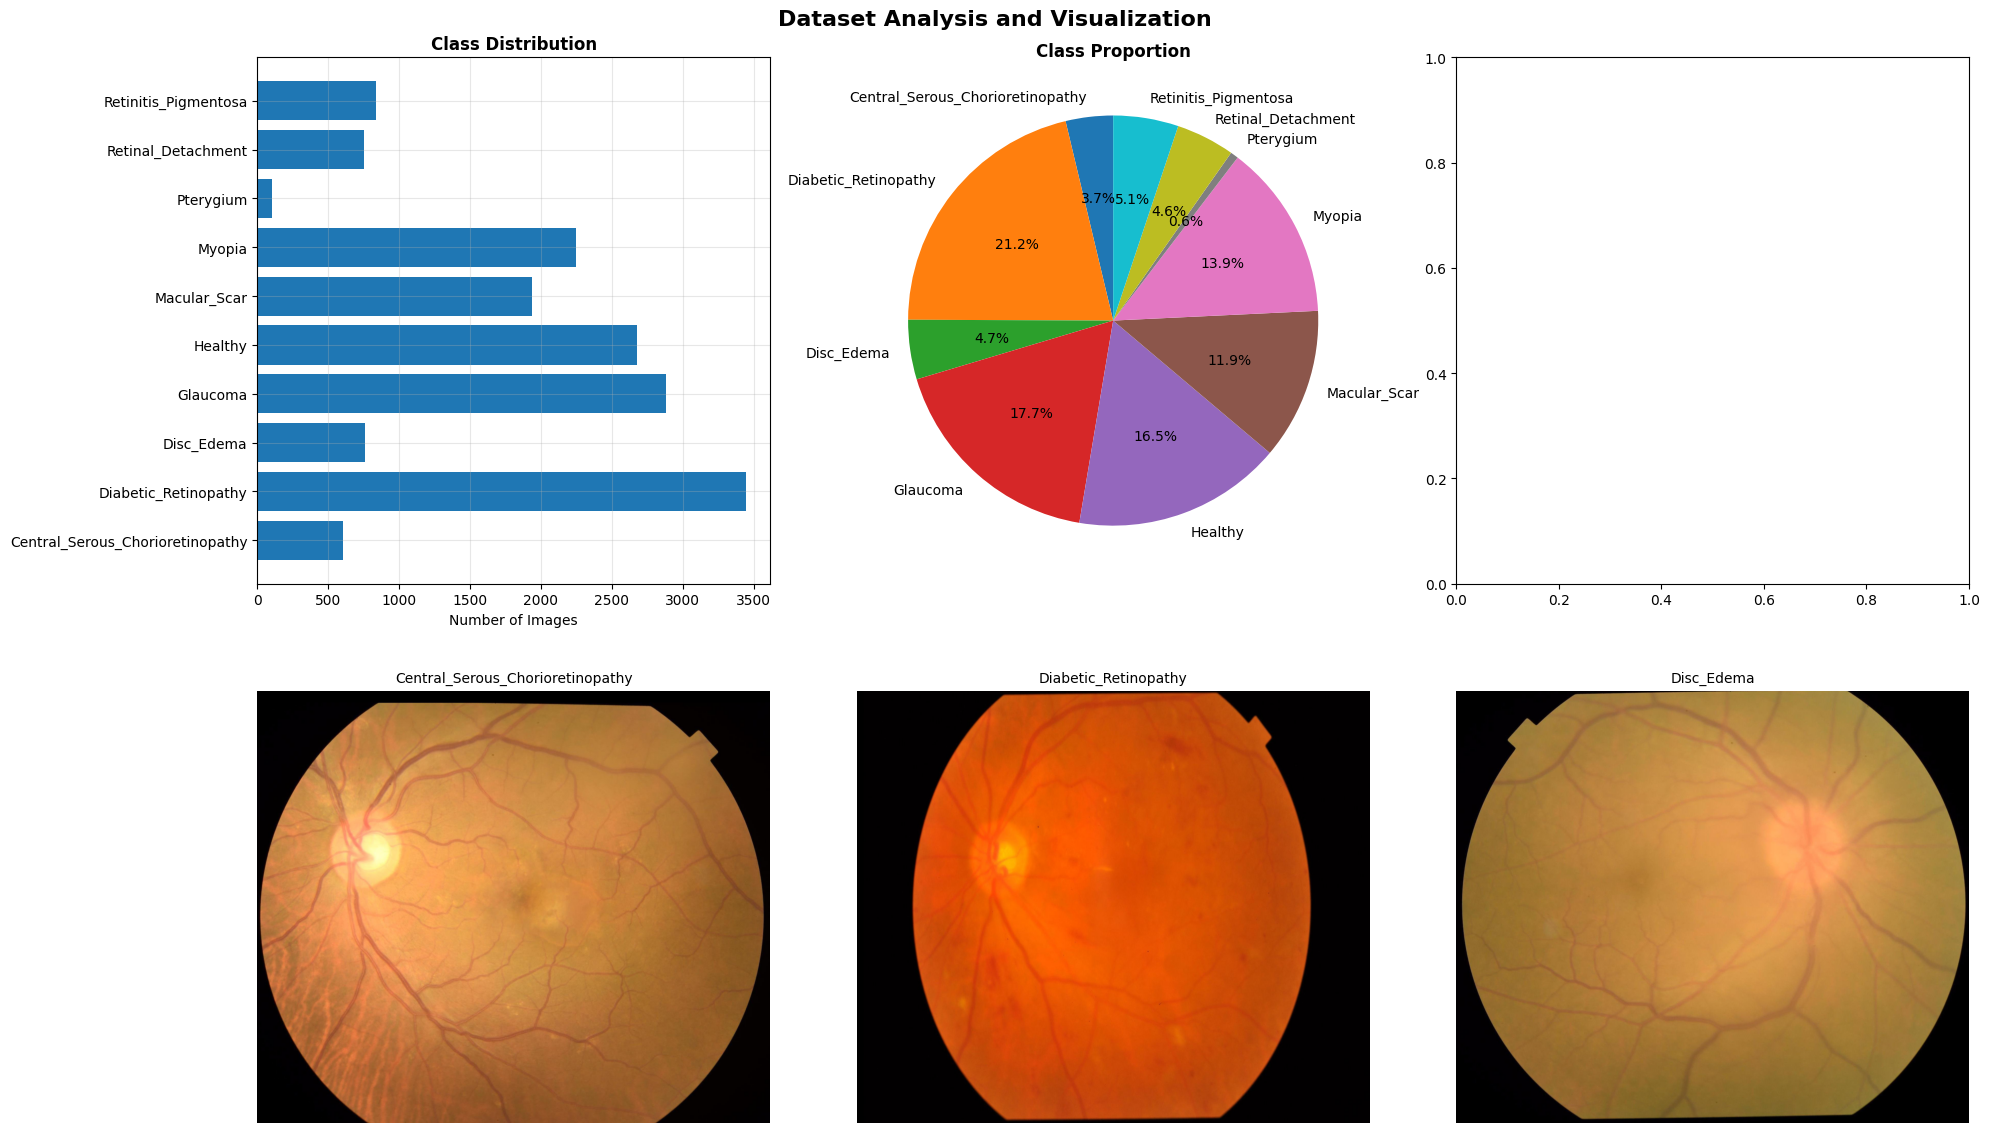

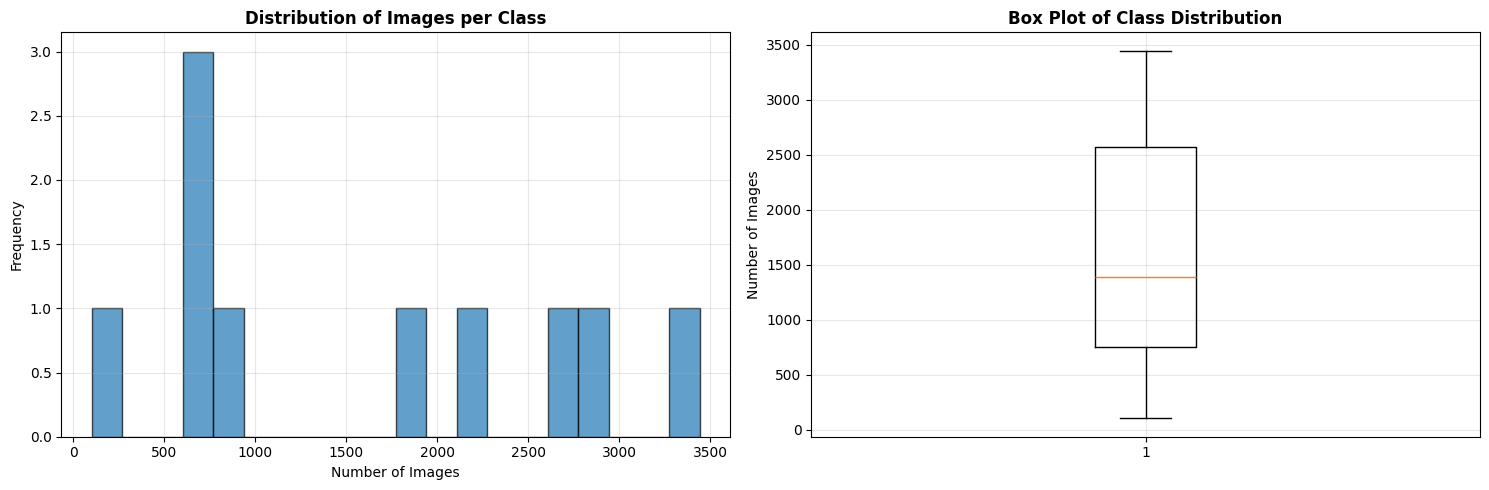


📂 Creating Data Generators...
Found 12997 images belonging to 10 classes.
Found 0 images belonging to 10 classes.
Training samples: 12997
Validation samples: 0

⚖️ Class Weights for Imbalance Handling:
  Central_Serous_Chorioretinopathy: 2.68
  Diabetic_Retinopathy: 0.47
  Disc_Edema: 2.13
  Glaucoma: 0.56
  Healthy: 0.61
  Macular_Scar: 0.84
  Myopia: 0.72
  Pterygium: 15.85
  Retinal_Detachment: 2.17
  Retinitis_Pigmentosa: 1.95

🏗️  BUILDING EFFICIENTNET MODEL
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

🚀 Training EfficientNet Model...
Epoch 1/50


ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.

In [77]:
# ============================================
# 14. EXECUTION
# ============================================

if __name__ == "__main__":
    
    # For Google Colab - Mount Google Drive
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        
        # Update paths for Colab
        Config.DATA_PATH = "/content/drive/MyDrive/data/augmented_images"  # Update this
        Config.MODEL_SAVE_PATH = "/content/drive/MyDrive/models/eye_disease"
        Config.LOGS_PATH = "/content/drive/MyDrive/logs/eye_disease"
        
        print("✅ Google Drive mounted successfully!")
        print(f"📁 Data path: {Config.DATA_PATH}")
        
    except:
        print("⚠️ Not running in Google Colab. Using local paths.")
    
    # Run the main pipeline
    results = main()